# Computer Vision – Thresholdings

En este notebook empezaremos a comprender los thresholdings o umbrales y por qué un valor de umbral T no debe proporcionarse manualmente. Probaremos el método de umbral de Otsu y ademas comprenderemos la importancia de los umbrales adaptativos y por qué es útil en situaciones donde las condiciones de iluminación no se pueden controlar.

¿Qué es el umbral? El umbral es la binarización de una imagen. En general, buscamos convertir una imagen en escala de grises a una imagen binaria, donde los píxeles son 0 o 255. Un ejemplo de umbral simple sería seleccionar un valor de umbral T, y luego configurar todas las intensidades de píxeles menores que T a cero, y todos los valores de píxeles mayores a T a 255. De esta manera, podemos crear una representación binaria de la imagen.

### Setup

In [1]:
import cv2
from skimage.filters import threshold_local

image = cv2.imread("C:/Users/algonzalez/source/repos/Computer_Vision/1_Basics_of_Computer_Vision/images/IMG_1009.JPG")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("Original", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Simple Thresholding

Comenzamos realizando un umbral simple que nos obliga a suministrar manualmente un valor de T para realizar el umbral. Sin embargo, nos damos cuenta rápidamente de que suministrar manualmente un valor de T es muy tedioso y nos obliga a programar este valor, lo que implica que este método no funcionará en todas las situaciones.

In [2]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
cv2.imshow("Image", image)

# Umbral básico - el primer parámetro es la imagen
# queremos de umbral, el segundo valor es nuestro umbral y
# comprobar si un valor de píxel es mayor que nuestro umbral (en este
# caso, 200), lo configuramos como NEGRO, de lo contrario es BLANCO.
(T, threshInv) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
cv2.imshow("Threshold Binary Inverse", threshInv)

# utilizando un umbral normal (en lugar de un umbral inverso),
# podemos cambiar el último argumento en la función para hacer la imagen
# negra en lugar de blanco.
(T, thresh) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
cv2.imshow("Threshold Binary", thresh)

# Finalmente, visualizaremos las regiones enmascaradas en la imagen.
cv2.imshow("Output", cv2.bitwise_and(image, image, mask=threshInv))
cv2.waitKey(0)
cv2.destroyAllWindows()

## Otsu Thresholding

Pasamos al método de umbral de Otsu, que calcula automáticamente el valor óptimo de T para nosotros asumiendo una distribución bimodal de la representación en escala de grises de nuestra imagen de entrada. El problema aquí es que:

1. Nuestras imágenes de entrada deben ser bimodales para que el método de Otsu obtenga resultados visualmente atractivos.
2. El método de Otsu es un método de umbral global, lo que implica que debemos tener al menos algún control sobre nuestras condiciones de iluminación. 

En situaciones en las que nuestras condiciones de iluminación no son las ideales, o simplemente no podemos controlarlas, analizamos los umbrales adaptativos (que también se conocen como umbrales locales). 

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
cv2.imshow("Image", image)

# El umbral automático de Otsu - el método de Otsu automáticamente
# determina el mejor valor de umbral `T` para nosotros
(T, threshInv) = cv2.threshold(blurred, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cv2.imshow("Threshold", threshInv)
print("Otsu's thresholding value: {}".format(T))

# Finalmente, visualizaremos las regiones enmascaradas en la imagen.
cv2.imshow("Output", cv2.bitwise_and(image, image, mask=threshInv))
cv2.waitKey(0)
cv2.destroyAllWindows()

Otsu's thresholding value: 120.0


## Adaptive Thresholding

Los umbrales adaptativos suponen que las regiones locales de una imagen tendrán una iluminación e iluminación más uniformes que la imagen en su conjunto. Por lo tanto, para obtener mejores resultados de umbrales, deberíamos investigar las subregiones de una imagen y establecer un umbral individual para obtener nuestra imagen de salida final.

In [4]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(image, (5, 5), 0)
cv2.imshow("Image", image)

# En lugar de especificar manualmente el valor de umbral, podemos usar adaptive Thresholding
# para examinar vecinos de píxeles y el umbral adaptativo para
# cada barrio: en este ejemplo, calcularemos el valor medio
# del área de los vecinos de 25 píxeles y el umbral basado en ese valor
# finalmente, nuestra constante C se resta del cálculo de la media (en este
# caso 15)
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 15)
cv2.imshow("OpenCV Mean Thresh", thresh)

# El umbral adaptativo scikit-image
T = threshold_local(blurred, 29, offset=5, method="gaussian")
thresh = (blurred < T).astype("uint8") * 255
cv2.imshow("scikit-image Mean Thresh", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Extract masks by thresholdings

In [5]:
import cv2 as cv
import numpy as np
import glob, os
from pathlib import Path
from matplotlib import pyplot as plt
import imutils
from PIL import Image

def resize_dataset(local_file):
    im = Image.open(local_file)
    size=(1022,767)
    im.thumbnail(size, Image.ANTIALIAS)
    im.save(local_file, quality=90)

def generate_mask(npimage):
    mask = np.zeros(npimage.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (31,30,1022,767)
    cv.grabCut(npimage,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    final_mask = npimage*mask2[:,:,np.newaxis]
    return final_mask

def generate_threshold(mask):
    grey_img = cv.cvtColor(mask, cv.COLOR_RGB2GRAY)
    img_medblur = cv.medianBlur(grey_img,5)
    th = cv.adaptiveThreshold(img_medblur,255,cv.ADAPTIVE_THRESH_MEAN_C,\
                cv.THRESH_BINARY_INV,9,2)
    return th

def convert_mask_to_bw(threshold):
    im = Image.fromarray(threshold)
    gray = im.convert('L')
    bw = gray.point(lambda x: 0 if x<128 else 255, '1')
    return bw

def save_masks_locally(local_file, th):
    filename = os.path.basename(local_file)
    name = os.path.splitext(filename)[0]
    bw = convert_mask_to_bw(th)
    bw.save(parent_path+"/dataset/test/"+name+".png")

def generate_plot_thresholds(mask):
    grey_img = cv.cvtColor(mask, cv.COLOR_RGB2GRAY)
    img_medblur = cv.medianBlur(grey_img,5)
    ret,th1 = cv.threshold(img_medblur,125,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    th2 = cv.adaptiveThreshold(img_medblur,255,cv.ADAPTIVE_THRESH_MEAN_C,\
                cv.THRESH_BINARY_INV,9,2)
    th3 = cv.adaptiveThreshold(img_medblur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv.THRESH_BINARY_INV,9,2)

    titles = ['Blur Image', 'MASK',
                'Mask Mean', 'Mask Gaussian']
    images = [img_medblur, th1, th2, th3]

    for i in range(4):
        plt.figure(figsize=(15,15))
        plt.subplot(2,2,i+1),plt.imshow(images[i],cmap='Greys')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

Reading file  C:\Users\algonzalez\source\repos\Sener-Images\source\dataset\Files\Set#3 2019 03 07\1.bmp


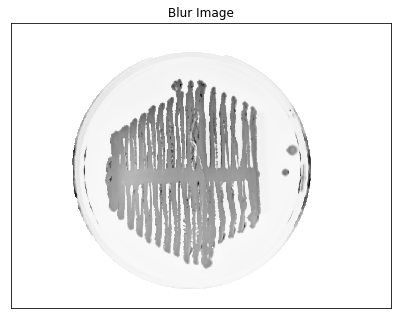

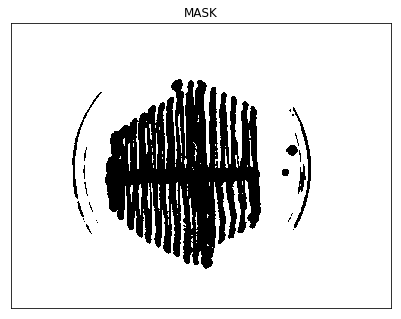

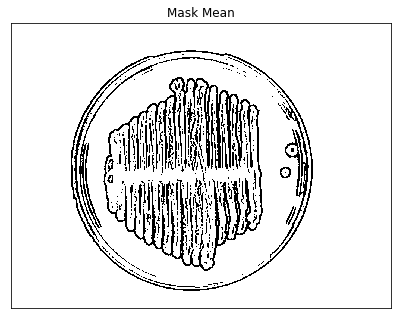

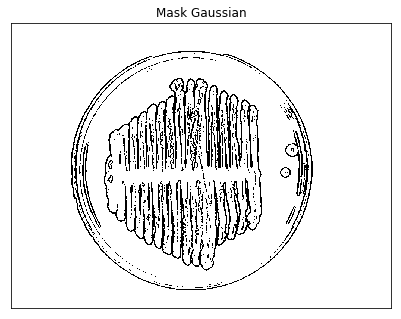

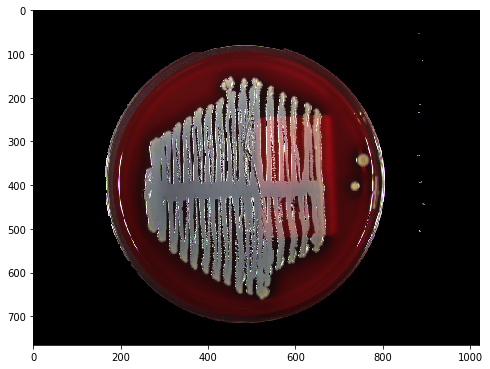

In [11]:
local_file_list = []
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))
pathlist = Path("C:/Users/algonzalez/source/repos/Sener-Images/source/dataset/Files/Set#3 2019 03 07").glob('**/*.bmp')
for path in pathlist:
    path_in_str = str(path)
    local_file_list.append(path_in_str)
    file_num = len(local_file_list)
    for i in range(file_num):
        local_file = os.path.join(local_file_list[i])
    print("Reading file ", local_file)
    resize_dataset(local_file)
    img = cv.imread(local_file)
    mask = generate_mask(img)
    rgb_img = cv.cvtColor(mask, cv.COLOR_RGB2BGR)
    generate_plot_thresholds(mask)
    filename = os.path.basename(local_file)
    name = os.path.splitext(filename)[0]
    bw = convert_mask_to_bw(rgb_img)
    plt.figure(figsize=(8,8))
    plt.imshow(rgb_img)
    plt.show()
    break